<a href="https://colab.research.google.com/github/Madmjce/Palm-recognition/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Môi Trường

In [ ]:
 from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/PalmDetection

/content/drive/MyDrive/Colab Notebooks/PalmDetection


In [ ]:
# !unzip -q abc.zip

In [ ]:
ls

data/   model_classification.png      preprocessing.ipynb
model/  model_feature_extraction.png  result.json


In [ ]:
!pip install mediapipe
# !pip install keras==2.3.1
# !pip install tensorflow==2.5.0

# Xử lý dữ liệu (tín hiệu số)

In [ ]:
import os
import cv2
import random
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
mp_draw = mp.solutions.drawing_utils
mp_hand = mp.solutions.hands

In [ ]:
hand = mp_hand.Hands(max_num_hands=1, min_detection_confidence=0.5)

In [ ]:
def get_lm(img, hand=hand):
    results = hand.process(img)
    if not results.multi_hand_landmarks:
        return None
    return results

In [ ]:
def preprocess(img, hand=hand, desiredHandWidth=221, desiredHandHeight=221):
    # BRG -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    results = get_lm(img)
    if results is None:
        return None
    
    # Flip if hand is upside down
    wrist = results.multi_hand_landmarks[0].landmark[0]
    if_mcp = results.multi_hand_landmarks[0].landmark[5]
    mf_mcp = results.multi_hand_landmarks[0].landmark[9]
    rf_mcp = results.multi_hand_landmarks[0].landmark[13]
    pf_mcp = results.multi_hand_landmarks[0].landmark[17]

    if all(y.y > wrist.y for y in [if_mcp, mf_mcp, rf_mcp, pf_mcp]):
        img = cv2.flip(img, 0)

    # Rotate to straight-up
    results = get_lm(img)
    if results is None:
        return None
    
    wrist = results.multi_hand_landmarks[0].landmark[0]
    if_mcp = results.multi_hand_landmarks[0].landmark[5]
    mf_mcp = results.multi_hand_landmarks[0].landmark[9]
    rf_mcp = results.multi_hand_landmarks[0].landmark[13]
    pf_mcp = results.multi_hand_landmarks[0].landmark[17]

    if all(x.x > wrist.x for x in [if_mcp, mf_mcp, rf_mcp, pf_mcp]):
        img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

    if all(x.x < wrist.x for x in [if_mcp, mf_mcp, rf_mcp, pf_mcp]):
        img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
    
    # Flip if to left handed
    results = get_lm(img)
    if results is None:
        return None
    
    tf_mcp = results.multi_hand_landmarks[0].landmark[2]
    pf_mcp = results.multi_hand_landmarks[0].landmark[17]

    if tf_mcp.x > pf_mcp.x:
        img = cv2.flip(img, 1)
    
    # Align hand
    results = get_lm(img)
    if results is None:
        return None

    if_mcp = results.multi_hand_landmarks[0].landmark[5]
    pf_mcp = results.multi_hand_landmarks[0].landmark[17]

    if_mcp.x, if_mcp.y = if_mcp.x*w, if_mcp.y*h
    pf_mcp.x, pf_mcp.y = pf_mcp.x*w, pf_mcp.y*h

    root = ((if_mcp.x + pf_mcp.x)//2, (if_mcp.y + pf_mcp.y)//2)

    dY = pf_mcp.y - if_mcp.y
    dX = pf_mcp.x - if_mcp.x
    angle = np.degrees(np.arctan2(dY, dX))

    if abs(angle) > 90:
        angle -= 180

    dist = np.sqrt(dY**2 + dX**2)
    desiredDist = 0.8 * desiredHandWidth
    scale = desiredDist / dist

    M = cv2.getRotationMatrix2D(root, angle, scale)

    tX = desiredHandWidth * 0.5
    tY = desiredHandHeight * 0.3
    
    M[0,2] += tX - root[0]
    M[1,2] += tY - root[1]
    
    aligned = cv2.warpAffine(img, M, (desiredHandWidth, desiredHandHeight), flags=cv2.INTER_CUBIC)

    # Get palm
    gauss = cv2.GaussianBlur(aligned, (5,5), cv2.BORDER_DEFAULT)

    gray = cv2.cvtColor(gauss, cv2.COLOR_RGB2GRAY)

    eq_gray = cv2.equalizeHist(gray)

    # # histogram equalization rgb
    # img_yuv = cv2.cvtColor(aligned, cv2.COLOR_RGB2YUV)
    # img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    canny = cv2.Canny(eq_gray, 100, 200)

    return canny

In [ ]:
def preprocess_and_save(input_path, output_path):
    for ppl in os.listdir(input_path):
        if not os.path.exists(f'{output_path}/{ppl}'):
            os.mkdir(f'{output_path}/{ppl}')
        print(ppl)
        for img_name in os.listdir(f'{input_path}/{ppl}'):
            print(img_name)
            img = cv2.imread(f'{input_path}/{ppl}/{img_name}')
            canny = preprocess(img)

            if canny is None:
                continue

            cv2.imwrite(f'{output_path}/{ppl}/{img_name}', canny)

In [ ]:
# preprocess real_db
preprocess_and_save(input_path='./data/Real_Db', output_path='./data/aligned')

# preprocess NotDb
preprocess_and_save(input_path='./data/NotDb', output_path='./data/aligned_NotDb')

# preprocess real_db
preprocess_and_save(input_path='./data/InDb', output_path='./data/aligned_InDb')

006_emchisan
206968058_840699106842969_4088787306209475017_n.jpg
210325046_780399035958017_5529195349864559689_n.jpg
213015685_339524617775824_1729202588965834325_n.jpg
209429006_1886579131516268_4693256482341055847_n.jpg
209823780_527319428691198_442459265731389815_n.jpg
207326533_220224133166856_1772392403271661007_n.jpg
207822883_4420663671291388_6643659782861473787_n.jpg
212239973_181844073912629_3467694943068066712_n.jpg
207671136_970169953822681_4000484405925158159_n.jpg
207484809_367647314691280_2124280246309197196_n.jpg
208161590_2320002378133235_3830536605374002697_n.jpg
210088688_504550347278400_4431539584995206273_n.jpg
002_ngla1
z2593036776857_9b46fbe01d0fe4ddd344ba81205eba6b.jpg
z2593036787322_a3aa11325f4ab2ac5af28e75363ba347 (1).jpg
z2593036838678_cf33e6f259bcad40b9a5f3822c26d431.jpg
z2593036763668_fcb1cd4fe870be7a78d81c6152616665.jpg
z2593036894962_68e9fe1eef43c3606b69543d5ce382b5.jpg
z2593036815737_2d65754c9b3fd1385997f48680ce3a62.jpg
z2593036800206_7a4dab6aebb258ea3a78

# Training feature extraction

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def convnet_model_():
    # vgg_model = keras.applications.VGG16(weights=None, include_top=False, input_shape=(221, 221, 3))
    # x = vgg_model.output
    cnn_input = Input(shape=(221, 221, 1))
    x = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(cnn_input)
    x = MaxPool2D(pool_size=(3,3), padding='same')(x)
    x = Conv2D(128, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(3,3), padding='same')(x)
    x = Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(3,3), padding='same')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = tf.nn.l2_normalize(x, axis=1)
    # x = Lambda(lambda x_: tf.math.l2_normalize(x,axis=1))(x)
#     x = Lambda(K.l2_normalize)(x)
    convnet_model = Model(inputs=cnn_input, outputs=x)
    return convnet_model

def deep_rank_model():
    convnet_model = convnet_model_()

    first_input = Input(shape=(221, 221, 1))
    first_conv = Conv2D(64, kernel_size=(3,3), strides=(16,16), padding='same', activation='relu')(first_input)
    first_max = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(first_conv)
    first_max = Flatten()(first_max)
    first_max = tf.nn.l2_normalize(first_max, axis=1)

    second_input = Input(shape=(221, 221, 1))
    second_conv = Conv2D(64, kernel_size=(3,3), strides=(32,32), padding='same', activation='relu')(second_input)
    second_max = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(second_conv)
    second_max = Flatten()(second_max)
    second_max = tf.nn.l2_normalize(second_max, axis=1)
                       
    merge_one = concatenate([first_max, second_max])
    merge_two = concatenate([merge_one, convnet_model.output])
    emb = Dense(256)(merge_two)
    emb = Dense(128)(emb)
    l2_norm_final = tf.nn.l2_normalize(emb, axis=1)
                        
    final_model = Model(inputs=[first_input, second_input, convnet_model.input], outputs=l2_norm_final)

    return final_model

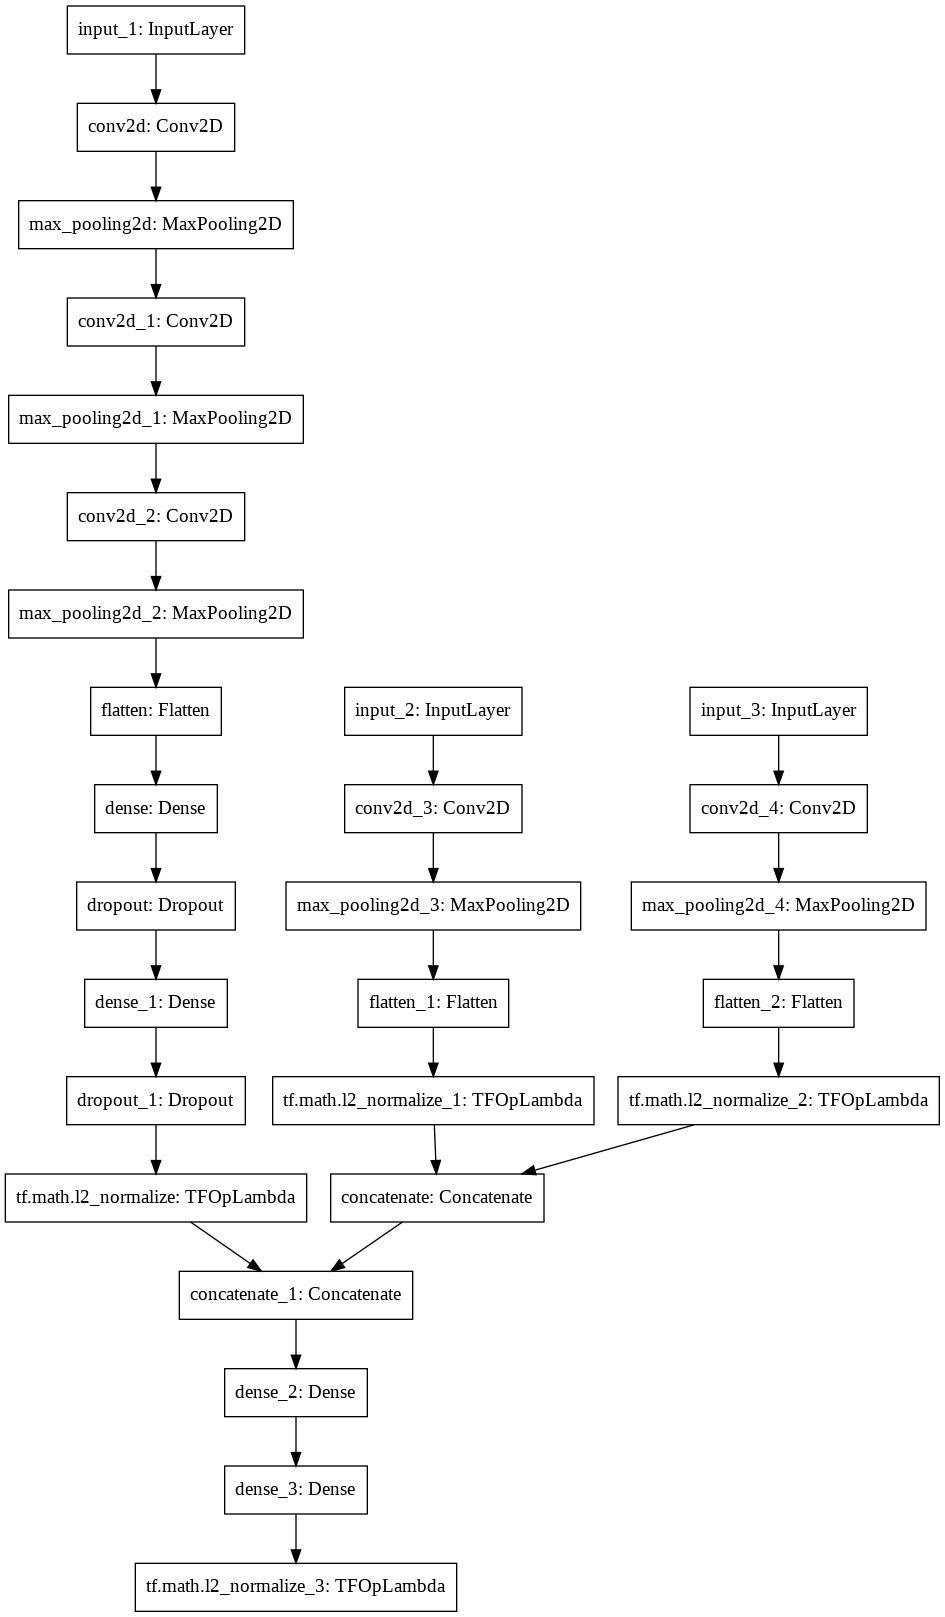

In [ ]:
# Xem cấu trúc model
from tensorflow.keras.utils import plot_model
model = deep_rank_model()
# model.summary()
plot_model(model, to_file='model_feature_extraction.png')

In [ ]:
batch_size = 24
_EPSILON = 1e-7
def _loss_tensor(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, _EPSILON, 1.0 - _EPSILON)
    loss = 0.
    g = 1.
    for i in range(0, batch_size, 3):
        try:
            q_embedding = y_pred[i]
            p_embedding = y_pred[i+1]
            n_embedding = y_pred[i+2]
            D_q_p = tf.math.sqrt(tf.math.reduce_sum((q_embedding - p_embedding)**2))
            D_q_n = tf.math.sqrt(tf.math.reduce_sum((q_embedding - n_embedding)**2))
            loss = loss + g + D_q_p - D_q_n
        except:
            continue
    loss = loss/batch_size*3
    return tf.math.maximum(loss, 0)

In [ ]:
def image_generator(img_path, batch_size=24):
    identities = os.listdir(img_path)
    anchor_id = 0
    while True:
        input_queue = []

        for i in range(batch_size//3):

            idp = identities[anchor_id%len(identities)]
            idn = random.choice(identities)
            while idn == idp:
                idn = random.choice(identities)
            anchor_id += 1

            input_queue += [np.expand_dims(cv2.imread(f'{img_path}/{idp}/{img_name}', cv2.IMREAD_UNCHANGED)/255.0, 2) for img_name in random.sample(os.listdir(f'{img_path}/{idp}'), 2)]
            input_queue += [np.expand_dims(cv2.imread(f'{img_path}/{idn}/{img_name}', cv2.IMREAD_UNCHANGED)/255.0, 2) for img_name in random.sample(os.listdir(f'{img_path}/{idn}'), 1)]

        input_queue = np.array(input_queue)

        yield ([input_queue, input_queue, input_queue], np.zeros((batch_size, )))

In [ ]:
gen = image_generator('./data/aligned')

In [ ]:
l = next(gen)
print(l[0][0].shape)

(24, 221, 221, 1)


In [ ]:
model.compile(loss=_loss_tensor, optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True))

In [ ]:
cb_es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
# Train 800 epochs without callback for firm performance
# Save model each 200 epochs
for i in range(4):
    model.fit_generator(generator=gen,
                    steps_per_epoch=300//batch_size,
                    epochs=200,
                    verbose=1)
    model.save_weights(f'./model/model64-{i}-2408.h5')

# Train 100 epochs with callback for best performance
model.fit_generator(generator=gen,
                   steps_per_epoch=360//batch_size,
                   epochs=100,
                   callbacks=[cb_es],
                   verbose=1)
model.save('./model/model128-best-2408.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
12/12 [==============================] - 6s 112ms/step - loss: 0.9707
Epoch 2/200
12/12 [==============================] - 1s 112ms/step - loss: 0.9812
Epoch 3/200
12/12 [==============================] - 1s 114ms/step - loss: 0.9757
Epoch 4/200
12/12 [==============================] - 1s 112ms/step - loss: 0.9713
Epoch 5/200
12/12 [==============================] - 1s 112ms/step - loss: 0.9504
Epoch 6/200
12/12 [==============================] - 1s 113ms/step - loss: 0.9554
Epoch 7/200
12/12 [==============================] - 1s 111ms/step - loss: 0.9416
Epoch 8/200
12/12 [==============================] - 1s 115ms/step - loss: 0.9428
Epoch 9/200
12/12 [==============================] - 1s 118ms/step - loss: 0.9386
Epoch 10/200
12/12 [==============================] - 1s 111ms/step - loss: 0.9240
Epoch 11/200
12/12 [==============================] - 1s 113ms/step - loss: 0.9354
Epoch 12/200
12/12 [==============================] - 1s 112ms/step - loss: 0.9294
Epoch 13/200


# Training classification

In [ ]:
md = deep_rank_model()
md.load_weights('./model/model128-best-2408.h5')

In [ ]:
# root_palm = {}
for person in os.listdir('./data/aligned'):
    if not os.path.exists(f'./data/emb/{person}'):
        os.mkdir(f'./data/emb/{person}')
    avg = 0
    count = 0
    for img_name in os.listdir(f'./data/aligned/{person}'):
        s1 = cv2.imread(f'./data/aligned/{person}/{img_name}', cv2.IMREAD_UNCHANGED)
        s1 = s1/255.0
        ip = np.expand_dims(s1, axis=2)
        ip = np.expand_dims(ip, axis=0)
        with open(f'./data/emb/{person}/{person}_{count}.txt', 'w+') as f:
            f.write(str([x for x in list(md.predict([ip, ip, ip])[0])]))
            f.close()
        
        # root_palm[person] = [str(x) for x in list(md.predict([ip, ip, ip])[0])]
        # break
    #     avg += md.predict([ip, ip, ip])[0]
        count += 1
    # avg = avg/count
    # root_palm[person] = [str(x) for x in list(avg)]

In [ ]:
import ast
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
def get_all_emb(data_path='./data/emb'):
    X = []
    y = []
    classes = {p:i for i,p in enumerate(os.listdir('./data/emb'))}
    for person in os.listdir(data_path):
        for txt in os.listdir(os.path.join(data_path, person)):
            f = open(os.path.join(data_path, person, txt), 'r')
            temp = f.read()
            f.close()
            X.append(np.array(ast.literal_eval(temp)))
        y += [classes[person]]*len(os.listdir(os.path.join(data_path, person)))
      
    return np.array(X), np.array(y)

In [ ]:
X, y = get_all_emb()

In [ ]:
y = to_categorical(y, len(os.listdir('./data/emb')))

In [ ]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=28)

In [ ]:
# Classification model
def init_dnn_classify(emb_size=128, num_classes=len(os.listdir('./data/emb'))):
    model = Sequential()
    model.add(Input(shape=(emb_size,)))
    # model.add(Dropout(0.2))
    # model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

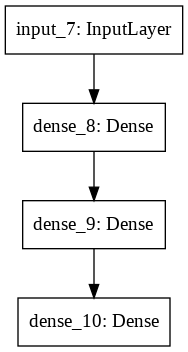

In [ ]:
# Xem cấu trúc model
from tensorflow.keras.utils import plot_model
dnn = init_dnn_classify()
# dnn.summary()
plot_model(dnn, to_file='model_classification.png')

In [ ]:
dnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
dnn.fit(X, y, batch_size=16, epochs=100, validation_split=0.2)
dnn.save('./model/dnn_2408.h5')

In [ ]:
dnn = init_dnn_classify()
dnn.load_weights('./model/dnn_2408.h5')

# Testing

In [ ]:
# import json
# # write json root_palm
# with open('result.json', 'w') as fp:
#     json.dump(root_palm, fp)
#     fp.close()

In [ ]:
# # read json root_palm
# f = open('result.json', 'r')
# root_palm = {key:np.array([float(x) for x in value]) for key, value in json.load(f).items()}
# f.close()

In [ ]:
classes = {p:i for i,p in enumerate(os.listdir('./data/emb'))}
classes_inv = {i:p for i,p in enumerate(os.listdir('./data/emb'))}

In [ ]:
# Test InDb
y_true = []
y_pred = []
for per in os.listdir('./data/InDb'):
    print("Ground truth: ", per)
    for img_name in os.listdir(f'./data/InDb/{per}'):
        img = cv2.imread(f'./data/InDb/{per}/{img_name}', cv2.IMREAD_UNCHANGED)
        img_canny = preprocess(img)
        if img_canny is not None:
            img_canny = img_canny/255.0
            ip = np.expand_dims(img_canny, axis=2)
            ip = np.expand_dims(ip, axis=0)

            emb = md.predict([ip, ip, ip])

            # result = min({per:np.linalg.norm(emb-val) for per,val in root_palm.items()}.items(), key = lambda x: x[1])

            prediction = dnn.predict(emb)[0]
            # print(prediction)
            predicted_person = classes_inv[np.argmax(prediction, 0)]

            # if np.max(prediction, 0) < 0.5:
            #     print("Day la nguoi la")
            # else:
            print(f"Day la {np.max(prediction, 0)} {predicted_person}")
            y_true.append(classes[per])
            y_pred.append(classes[predicted_person])
        else:
            print("Cannot detect hand")

Ground truth:  019_thaohieu
Day la 0.1930096298456192 011_mom
Day la 0.1594548225402832 006_duclong
Ground truth:  033_giahuy
Day la 0.15536388754844666 017_sister
Day la 0.25093531608581543 001_vupham
Day la 0.20868080854415894 023_baotran
Day la 0.1884964555501938 023_baotran
Day la 0.21551238000392914 023_baotran
Day la 0.13682588934898376 012_nhulong
Day la 0.21377040445804596 017_sister
Day la 0.15339836478233337 023_baotran
Day la 0.18040421605110168 023_baotran
Day la 0.15916211903095245 017_sister
Ground truth:  015_phuongbao
Cannot detect hand
Day la 0.2083730697631836 011_mom
Ground truth:  011_mom
Day la 0.2226182371377945 011_mom
Day la 0.1515008956193924 006_duclong
Day la 0.16482257843017578 006_duclong
Day la 0.17088797688484192 006_duclong
Ground truth:  014_ny
Day la 0.13997453451156616 020_minhtoan
Day la 0.12024436891078949 009_khanhhuyen
Ground truth:  007_haiphan
Day la 0.16874606907367706 006_duclong
Day la 0.1603216975927353 006_duclong
Day la 0.19250455498695374

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print("accuracy score: ", accuracy_score(y_true, y_pred))
print("f1 score: ", f1_score(y_true, y_pred, average='micro'))

accuracy score:  0.043478260869565216
f1 score:  0.043478260869565216


In [ ]:
# Test NotDb
for per in os.listdir('./data/NotDb'):
    print("Ground truth: ", per)
    for img_name in os.listdir(f'./data/NotDb/{per}'):
        img = cv2.imread(f'./data/NotDb/{per}/{img_name}', cv2.IMREAD_UNCHANGED)
        img_canny = preprocess(img)
        if img_canny is not None:
            img_canny = img_canny/255.0
            ip = img_canny
            ip = np.expand_dims(ip, axis=0)

            emb = md.predict([ip, ip, ip])

            # result = min({per:np.linalg.norm(emb-val) for per,val in root_palm.items()}.items(), key = lambda x: x[1])
            prediction = dnn.predict(emb)[0]
            # print(prediction)
            predicted_person = classes_inv[np.argmax(prediction, 0)]

            if np.max(prediction, 0) < 0.9:
                print("Day la nguoi la")
            else:
                print(f"Day la {np.max(prediction, 0)} {predicted_person}")
        else:
            print("Cannot detect hand")